In [1]:
import os
import sys
import glob
import pickle
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.cm import ScalarMappable
import matplotlib.patches as mpatches
from matplotlib.colors import LogNorm

def pval_heatmap_ihc(df, name):
    import numpy as np
    import seaborn as sns
    import marsilea as ma
    from marsilea.plotter import TextMesh, Colors, MarkerMesh

    mask = np.tril(np.ones(df.shape), k=0).astype(bool)
    data_df = df.mask(mask)
    data = data_df.to_numpy()
    cols = data_df.columns
    rows = data_df.index

    def get_responder(info):
        return ['0' if x.startswith('0') else '1-19' if x.startswith('1') else '>20' for x in info]

    def get_stratification(info):
        return ['Intermediate' if x.endswith('e') else 'High' for x in info]

    colors = sns.color_palette("colorblind", 10)
    c7, c2, c3, c1, c4 = colors[7], colors[2], colors[3], colors[1], colors[4]
    resp_palette = {'0': c7, '1-19': c1, '>20': c4}
    strat_palette = {'High': c3, 'Intermediate': c2}

    col_resp  = Colors(get_responder(cols),      label="PD-L1 IHC", palette=resp_palette, label_loc='left')
    col_strat = Colors(get_stratification(cols), label="Stratification",      palette=strat_palette, label_loc='left')
    row_resp  = Colors(get_responder(rows),      label="PD-L1 IHC", palette=resp_palette)
    row_strat = Colors(get_stratification(rows), label="Stratification",      palette=strat_palette)

    min_p = np.nanmin(data[data > 0])
    log_norm = LogNorm(vmin=0.001, vmax=1)

    h = ma.Heatmap(
        data,
        linewidth=1,
        label="p-value",
        cmap="PuRd_r",
        norm=log_norm,
        width=2.75, height=2.75
    )
    mesh = MarkerMesh(np.eye(6), color="black", marker="x", size=50)
    h.add_layer(TextMesh(data, color="white", rotation=-45), name="text")
    h.add_layer(mesh, name="text")
    h.add_right(row_strat, size=0.2, pad=0.05)
    h.add_right(row_resp,  size=0.2, pad=0.00)
    h.add_top(col_strat,   size=0.2, pad=0.05)
    h.add_top(col_resp,    size=0.2, pad=0.00)

    h.add_legends(stack_size=4)
    h.render()
    plt.savefig(f"{name}.pdf", bbox_inches="tight")

In [3]:
df = pd.read_csv("../../Supplementary_Tables/ST7/ST7.csv", skiprows=1)[['Group 1', 'Group 2', 'p-value', 'Group 1.1', 'Group 2.1', 'p-value.1']]
df.columns=['DFSG1', 'DFSG2', 'DFSP', 'OSG1', 'OSG2', 'OSP']

In [4]:
def create_similarity_matrix(df_sub, group_col1, group_col2, value_col):
    df_sub = df_sub.dropna(subset=[group_col1, group_col2, value_col]).copy()
    df_sub[group_col1] = df_sub[group_col1].astype(str)
    df_sub[group_col2] = df_sub[group_col2].astype(str)
    matrix = df_sub.pivot(index=group_col1, columns=group_col2, values=value_col)
    matrix_full = matrix.combine_first(matrix.T)
    for g in matrix_full.index:
        matrix_full.loc[g, g] = 1.0
    return matrix_full

dfs_responder = df[df["DFSG1"].str.contains("Responder|Non-Responder") & df["DFSG2"].str.contains("Responder|Non-Responder")]
dfs_ihc = df[df["DFSG1"].str.contains(r"\d") & df["DFSG2"].str.contains(r"\d")]
dfs_tf = df[df["DFSG1"].str.contains("Tumor Fraction") & df["DFSG2"].str.contains("Tumor Fraction")]

os_responder = df[df["OSG1"].str.contains("Responder|Non-Responder") & df["OSG2"].str.contains("Responder|Non-Responder")]
os_ihc = df[df["OSG1"].str.contains(r"\d") & df["OSG2"].str.contains(r"\d")]
os_tf = df[df["OSG1"].str.contains("Tumor Fraction") & df["OSG2"].str.contains("Tumor Fraction")]

mat_dfs_responder = create_similarity_matrix(dfs_responder, "DFSG1", "DFSG2", "DFSP")
mat_dfs_ihc = create_similarity_matrix(dfs_ihc, "DFSG1", "DFSG2", "DFSP")
mat_dfs_tf = create_similarity_matrix(dfs_tf, "DFSG1", "DFSG2", "DFSP")

mat_os_responder = create_similarity_matrix(os_responder, "OSG1", "OSG2", "OSP")
mat_os_ihc = create_similarity_matrix(os_ihc, "OSG1", "OSG2", "OSP")
mat_os_tf = create_similarity_matrix(os_tf, "OSG1", "OSG2", "OSP")

responder_order = ["Responder (Intermediate)", "Non-Responder (Intermediate)", "Responder (High)", "Non-Responder (High)"]
ihc_order = ["0 (Intermediate)", "0 (High)", "1–19 (Intermediate)", "1–19 (High)", ">20 (Intermediate)", ">20 (High)"]
tf_order = ["Low Tumor Fraction (Intermediate)", "Low Tumor Fraction (High)", "High Tumor Fraction (Intermediate)", "High Tumor Fraction (High)"]

def reorder_matrix(matrix, order):
    return matrix.reindex(index=reversed(order), columns=order)

mat_dfs_responder = reorder_matrix(mat_dfs_responder, responder_order)
mat_dfs_ihc = reorder_matrix(mat_dfs_ihc, ihc_order)
mat_dfs_tf = reorder_matrix(mat_dfs_tf, tf_order)

mat_os_responder = reorder_matrix(mat_os_responder, responder_order)
mat_os_ihc = reorder_matrix(mat_os_ihc, ihc_order)
mat_os_tf = reorder_matrix(mat_os_tf, tf_order)


array([[0.0573, 0.0432, 0.384 ,    nan],
       [0.265 , 0.236 ,    nan,    nan],
       [0.833 ,    nan,    nan,    nan],
       [   nan,    nan,    nan,    nan]])

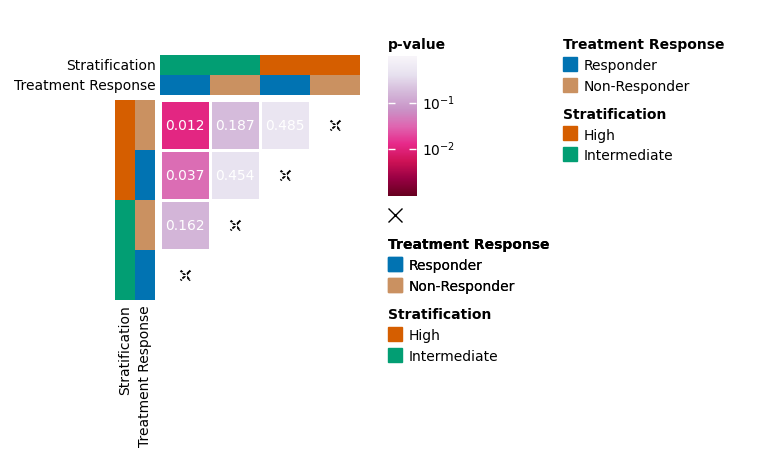

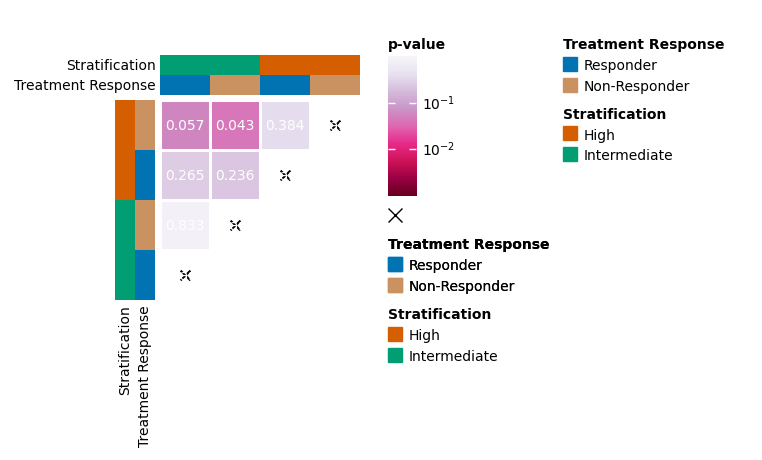

In [5]:
def pval_heatmap_response(df, name):
    import numpy as np
    import seaborn as sns
    import marsilea as ma
    from marsilea.plotter import TextMesh, Colors, MarkerMesh

    mask = np.fromfunction(lambda i, j: i + j < df.shape[0] - 1, df.shape)
    data_df = df.mask(~mask)
    data = data_df.to_numpy()
    cols = data_df.columns
    rows = data_df.index

    def get_responder(info):
        return ['Non-Responder' if x.startswith('N') else 'Responder' for x in info]
    def get_stratification(info):
        return ['Intermediate' if 'Intermediate' in x else 'High' for x in info]

    colors = sns.color_palette("colorblind", 6)
    c0, c2, c3, c5 = colors[0], colors[2], colors[3], colors[5]
    resp_palette = {'Responder': c0, 'Non-Responder': c5}
    strat_palette = {'High': c3, 'Intermediate': c2}

    col_resp  = Colors(get_responder(cols),      label="Treatment Response", palette=resp_palette, label_loc='left')
    col_strat = Colors(get_stratification(cols), label="Stratification",      palette=strat_palette, label_loc='left')
    row_resp  = Colors(get_responder(rows),      label="Treatment Response", palette=resp_palette)
    row_strat = Colors(get_stratification(rows), label="Stratification",      palette=strat_palette)

    min_p = np.nanmin(data[data > 0])
    log_norm = LogNorm(vmin=0.001, vmax=1)

    h = ma.Heatmap(
        data,
        linewidth=1,
        label="p-value",
        cmap="PuRd_r",
        norm=log_norm,
        width=2, height=2
    )
    mesh = MarkerMesh(np.fliplr(np.eye(4)), color="black", marker="x", size=50)
    h.add_layer(mesh, name="text")
    h.add_layer(TextMesh(np.round(data, 3), color="white"), name="text")
    h.add_left(row_resp,  size=0.2, pad=0.05)
    h.add_left(row_strat, size=0.2, pad=0.00)
    h.add_top(col_resp,    size=0.2, pad=0.05)
    h.add_top(col_strat,   size=0.2, pad=0.00)

    h.add_legends(stack_size=4)
    h.render()
    plt.savefig(f"{name}.pdf", bbox_inches="tight")
    return data

pval_heatmap_response(mat_dfs_responder, name='Prediction_DFS')
pval_heatmap_response(mat_os_responder, name='Prediction_OS')

[[0.203  0.0769 0.393     nan]
 [0.668  0.023     nan    nan]
 [0.0114    nan    nan    nan]
 [   nan    nan    nan    nan]]
[[0.642   0.354   0.018       nan]
 [0.0494  0.00376     nan     nan]
 [0.199       nan     nan     nan]
 [    nan     nan     nan     nan]]


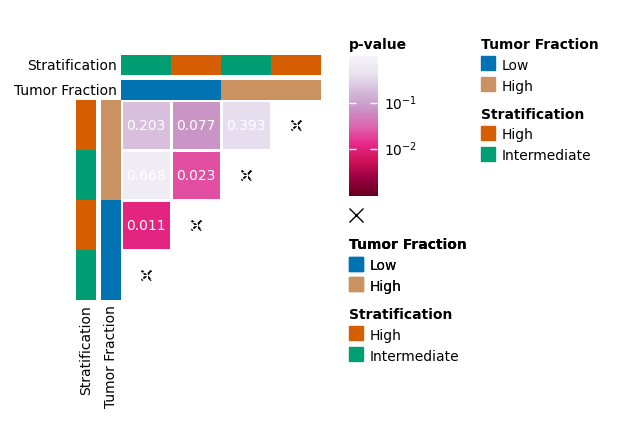

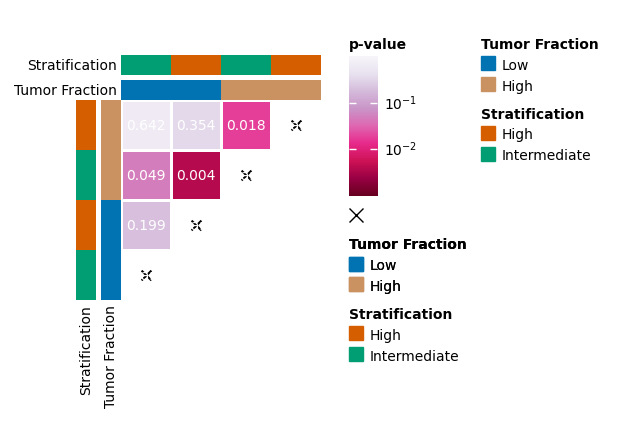

In [6]:
def pval_heatmap_tumor(df, name):
    import numpy as np
    import seaborn as sns
    import marsilea as ma
    from marsilea.plotter import TextMesh, Colors, MarkerMesh

    mask = np.fromfunction(lambda i, j: i + j < df.shape[0] - 1, df.shape)
    data_df = df.mask(~mask)
    data = data_df.to_numpy()
    cols = data_df.columns
    rows = data_df.index

    def get_responder(info):
        return ['Low' if x.startswith('L') else 'High' for x in info]
    def get_stratification(info):
        return ['Intermediate' if 'Intermediate' in x else 'High' for x in info]

    colors = sns.color_palette("colorblind", 6)
    c0, c2, c3, c5 = colors[0], colors[2], colors[3], colors[5]
    resp_palette = {'Low': c0, 'High': c5}
    strat_palette = {'High': c3, 'Intermediate': c2}

    col_resp  = Colors(get_responder(cols),      label="Tumor Fraction", palette=resp_palette, label_loc='left')
    col_strat = Colors(get_stratification(cols), label="Stratification",      palette=strat_palette, label_loc='left')
    row_resp  = Colors(get_responder(rows),      label="Tumor Fraction", palette=resp_palette)
    row_strat = Colors(get_stratification(rows), label="Stratification",      palette=strat_palette)

    min_p = np.nanmin(data[data > 0])
    log_norm = LogNorm(vmin=0.001, vmax=1)

    h = ma.Heatmap(
        data,
        linewidth=1,
        label="p-value",
        cmap="PuRd_r",
        norm=log_norm,
        width=2, height=2
    )
    mesh = MarkerMesh(np.fliplr(np.eye(4)), color="black", marker="x", size=50)
    h.add_layer(mesh, name="text")
    h.add_layer(TextMesh(np.round(data, 3), color="white"), name="text")
    h.add_left(row_resp,  size=0.2, pad=0.00)
    h.add_left(row_strat, size=0.2, pad=0.05)
    h.add_top(col_resp,    size=0.2, pad=0.00)
    h.add_top(col_strat,   size=0.2, pad=0.05)
    

    h.add_legends(stack_size=4)
    h.render()
    plt.savefig(f"{name}.pdf", bbox_inches="tight")
    print(data)

pval_heatmap_tumor(mat_dfs_tf, name='TF_DFS')
pval_heatmap_tumor(mat_os_tf, name='TF_OS')

[[0.151  0.765  0.0855 0.944  0.0735    nan]
 [0.322  0.167  0.404  0.116     nan    nan]
 [0.23   0.64   0.0742    nan    nan    nan]
 [0.606  0.227     nan    nan    nan    nan]
 [0.418     nan    nan    nan    nan    nan]
 [   nan    nan    nan    nan    nan    nan]]
[[0.135  0.688  0.0354 0.816  0.274     nan]
 [0.941  0.512  0.661  0.292     nan    nan]
 [0.239  0.532  0.0331    nan    nan    nan]
 [0.505  0.109     nan    nan    nan    nan]
 [0.469     nan    nan    nan    nan    nan]
 [   nan    nan    nan    nan    nan    nan]]


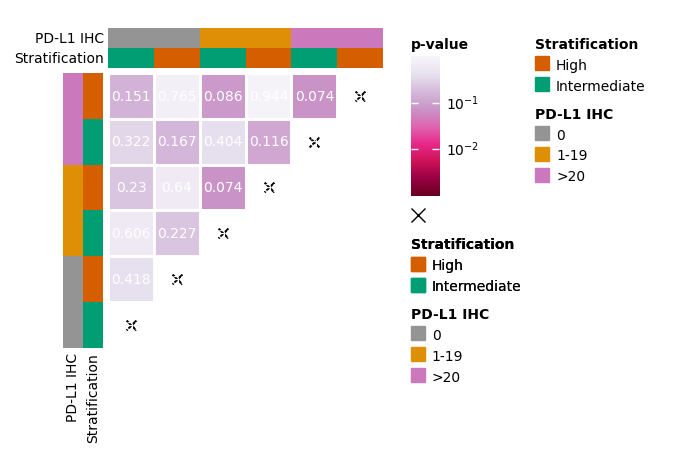

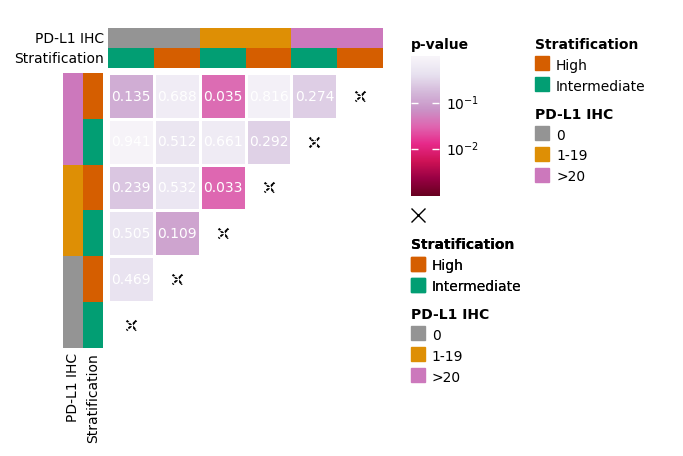

In [7]:
def pval_heatmap_ihc(df, name):
    import numpy as np
    import seaborn as sns
    import marsilea as ma
    from marsilea.plotter import TextMesh, Colors, MarkerMesh

    mask = np.fromfunction(lambda i, j: i + j < df.shape[0] - 1, df.shape)
    data_df = df.mask(~mask)
    data = data_df.to_numpy()
    cols = data_df.columns
    rows = data_df.index

    def get_responder(info):
        return ['0' if x.startswith('0') else '1-19' if x.startswith('1') else '>20' for x in info]

    def get_stratification(info):
        return ['Intermediate' if 'Intermediate' in x else 'High' for x in info]

    colors = sns.color_palette("colorblind", 10)
    c7, c2, c3, c1, c4 = colors[7], colors[2], colors[3], colors[1], colors[4]
    resp_palette = {'0': c7, '1-19': c1, '>20': c4}
    strat_palette = {'High': c3, 'Intermediate': c2}

    col_resp  = Colors(get_responder(cols),      label="PD-L1 IHC", palette=resp_palette, label_loc='left')
    col_strat = Colors(get_stratification(cols), label="Stratification",      palette=strat_palette, label_loc='left')
    row_resp  = Colors(get_responder(rows),      label="PD-L1 IHC", palette=resp_palette)
    row_strat = Colors(get_stratification(rows), label="Stratification",      palette=strat_palette)

    min_p = np.nanmin(data[data > 0])
    log_norm = LogNorm(vmin=0.001, vmax=1)

    h = ma.Heatmap(
        data,
        linewidth=1,
        label="p-value",
        cmap="PuRd_r",
        norm=log_norm,
        width=2.75, height=2.75
    )
    mesh = MarkerMesh(np.fliplr(np.eye(6)), color="black", marker="x", size=50)
    h.add_layer(TextMesh(np.round(data, 3), color="white"), name="text")
    h.add_layer(mesh, name="text")
    h.add_left(row_strat, size=0.2, pad=0.05)
    h.add_left(row_resp,  size=0.2, pad=0.00)
    h.add_top(col_strat,   size=0.2, pad=0.05)
    h.add_top(col_resp,    size=0.2, pad=0.00)

    h.add_legends(stack_size=4)
    h.render()
    plt.savefig(f"{name}.pdf", bbox_inches="tight")
    print(data)

pval_heatmap_ihc(mat_dfs_ihc, name='IHC_DFS')
pval_heatmap_ihc(mat_os_ihc, name='IHC_OS')